In [1]:
#载入基本库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot') #图形使用ggplot样式
%matplotlib inline  

In [2]:
#载入sklearn 创建数据集模块
from sklearn.datasets import make_classification,make_circles,make_moons,make_biclusters

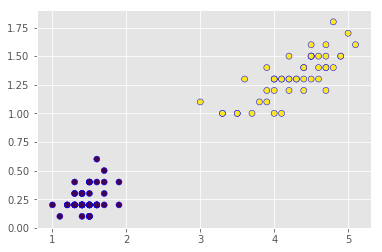

In [6]:
#载入iris数据集
from sklearn import datasets
import numpy as np
iris= datasets.load_iris()
x=iris.data[:,[2,3]]
y=iris.target
x=x[y<2,:]
y=y[y<2]
plt.scatter(x[:,0],x[:,1],c=y,edgecolors='b')

In [7]:
#创造moon，circle数据集，来自sklearn http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]
x_moon =datasets[0][0]
y_moon =datasets[0][1]
x_circle = datasets[1][0]
y_circle = datasets[1][1]

Text(0.5,1,'circle_like datasets')

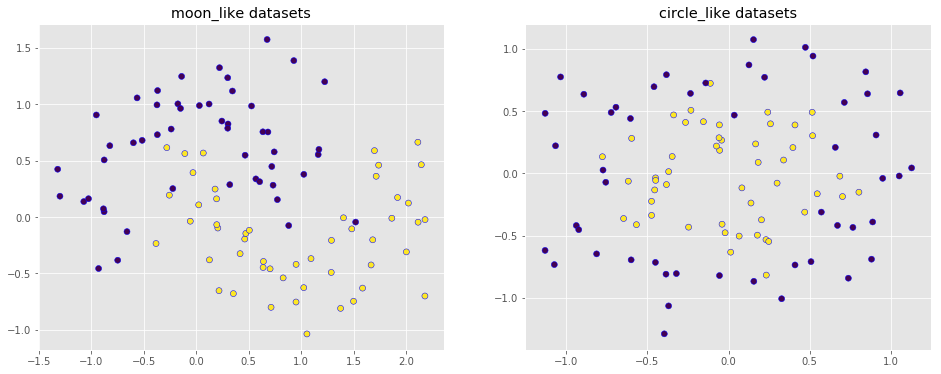

In [8]:
fig,ax =plt.subplots(1,2,figsize=(16,6))
ax[0].scatter(datasets[0][0][:,0],datasets[0][0][:,1],c=datasets[0][1],edgecolors='b')
ax[0].set_title('moon_like datasets')

ax[1].scatter(datasets[1][0][:,0],datasets[1][0][:,1],c=datasets[1][1],edgecolors='b')
ax[1].set_title('circle_like datasets')

In [56]:
#画决策边界
from matplotlib.colors import ListedColormap
def plot_decision_regions(X,y,classifier,resolution=0.02):
    #标记和颜色
    markers=("s",'x','o','^','v')
    colors=('red','blue','lightgreen','gray','cyan')
    cmap=ListedColormap(colors[:len(np.unique(y))])
    #画
    x1_min,x1_max=X[:,0].min()-1,X[:,0].max()+1
    x2_min,x2_max=X[:,1].min()-1,X[:,1].max()+1
    xx1,xx2=np.meshgrid(np.arange(x1_min,x1_max,resolution),np.arange(x2_min,x2_max,resolution))
    z=classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    z=z.reshape(xx1.shape)
    plt.contourf(xx1,xx2,z,alpha=0.4,cmap=cmap)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    #plot class samples
    for idx,cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0],y=X[y==cl,1],alpha=0.8,c=cmap(idx),marker=markers[idx],label=cl,edgecolors='b')

***
***
## 广义线性模型

y=g(wx+b)

***
### 1. 感知机

In [15]:
import numpy as np
class Perceptron(object):
    def __init__(self,eta=0.01,n_iter=100):
        self.eta=eta
        self.n_iter=n_iter
    def fit(self,X,y):
        self.w_=np.zeros(1+X.shape[1])
        self.errors_=[]
        for _ in range(self.n_iter):
            errors=0
            for xi,target in zip(X,y):
                update=self.eta*(self.predict(xi)-target)
                self.w_[1:]-=update*xi 
                self.w_[0]-=update
                errors+=int(update!=0.)#不等于0，就自加一个错误分类
            self.errors_.append(errors)
        return self  
    def net_input(self,X):
        return np.dot(X,self.w_[1:])+self.w_[0]
    def predict(self,X):
        return np.where(self.net_input(X)>=0.,1,-1)

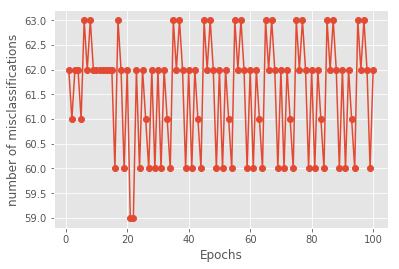

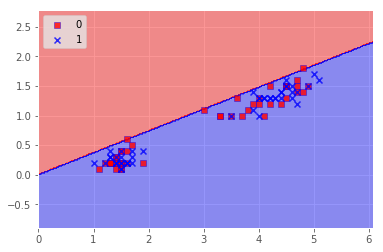

In [16]:
ppn=Perceptron()
ppn.fit(x,y)
plt.plot(range(1,len(ppn.errors_)+1),ppn.errors_,marker='o')
plt.xlabel('Epochs')
plt.ylabel("number of misclassifications")
plt.show()
plot_decision_regions(x,y,classifier=ppn)

plt.legend(loc='upper left')
plt.show()

***
### 2.Adaline BGD

In [425]:

class AdalineGD(object):
    def __init__(self,eta=0.001,n_iter=50):
        self.eta=eta
        self.n_iter=n_iter
    def fit(self,X,y):
        self.w_=np.zeros(1+X.shape[1])
        self.cost_=[]
        for _ in range(self.n_iter):
            output =self.net_input(X) #用线性激活函数的激活值，而非分类结果
            errors=(output-y)
            self.w_[1:]-=self.eta*X.T.dot(errors) #更新权重
            self.w_[0]-=self.eta*errors.sum() #更新偏置
            cost=(errors**2).sum()/2
            self.cost_.append(cost)
        return self  #
    def net_input(self,X):
        return np.dot(X,self.w_[1:])+self.w_[0]
    def activation(self,X):
        return self.net_input(X)
    def predict(self,X):
        return np.where(self.activation(X)>=0.5,1,0)# 或者0,1，-1，但需要改变y的label 0 改为-1

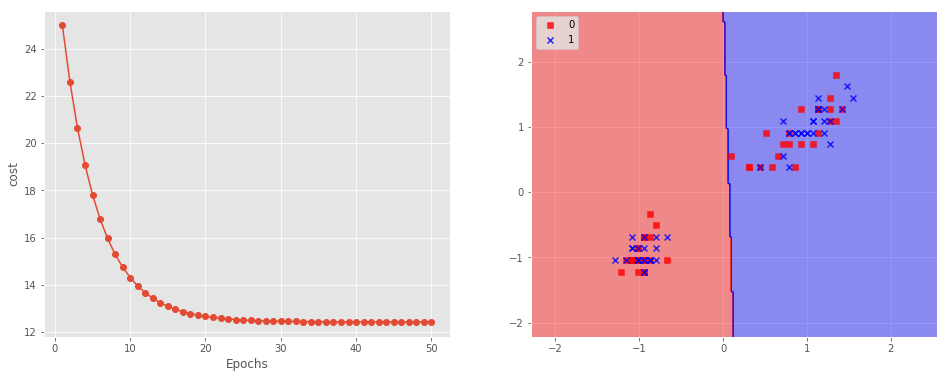

In [426]:
#标准化
x_std=(x-x.mean(axis=0))/x.std(axis=0)
#训练
ada=AdalineGD()
ada.fit(x_std,y)
fig,ax = plt.subplots(1,2, figsize=(16,6))

ax[0].plot(range(1,len(ada.cost_)+1),ada.cost_,marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel("cost")

plot_decision_regions(x_std,y,classifier=ada)

ax[1].legend(loc='upper left')


***
### 3.逻辑回归

In [55]:

class LogisticRegression(object):
    def __init__(self,eta=0.01,n_iter=60,lambd=1.,degree=None):
        self.eta = eta #学习速率
        self.n_iter = n_iter #迭代次数
        self.lambd = lambd #正则化
        self.degree = degree #映射多项式特征的最大幂；
    def fit(self,X,y): #拟合数据
        '''
        -----------------------------------
        X：shape 为 num_datas * num_featrue
        y：shape 为 num_datas*1，值应为0,1
        -----------------------------------
        '''
       
        degree = self.degree #记录self.degree的值 
        if self.degree:
            X = self.mapFeature(X)            
            self.degree = None #因为下面会调用predict函数，防止重新mapFeature
        
        self.w_ = np.zeros(1+X.shape[1]) # 偏置+权重，应在mapfeature()之后
        self.cost_=[] #记录迭代过程中代价值
        self.acc_=[]  #记录迭代过程中的准确度
        for _ in range(self.n_iter):
            self.update(X,y) #更新权重和偏置单元
            self.cost_.append(self.cost(X,y)) 
            self.acc_.append(self.accuracy(X,y))
        self.degree = degree # 重新将self.degree设置为原值
        return self  
    def mapFeature(self,X):  #映射多项式特征函数
        out = np.ones((X.shape[0],1))
        for i in np.arange(1,self.degree+1):
            for j in range(i+1):
                temp = X[:,0]**(i-j)*(X[:,1]**j)
                out = np.hstack((out,temp.reshape(-1,1)))
        return out

    def net_input(self,X):  #计算净输出值
        return np.dot(X,self.w_[1:])+self.w_[0] 
    
    def activation(self,X): #计算sigmoid函数激活值
        return 1./(1+np.exp(-1.*(self.net_input(X))))
    def cost(self,X,y): #计算代价函数
        m=X.shape[0]
        y_act=self.activation(X)
        loss=(-y*np.log(y_act)-(1-y)*np.log(1-y_act)).sum()+self.lambd*self.w_[1:].dot(self.w_[1:].T)*1./2 
        return loss/m  #log损失函数+L2正则化
    
    def gradient(self,X,y): #计算梯度
        y_act = self.activation(X) #激活值
        grad_weights = X.T.dot(y_act-y)+self.lambd*self.w_[1:] #梯度下降更新权重
        grad_bias = (y_act-y).sum() #更新偏置
        return  grad_bias,grad_weights
    
    def update(self,X,y): #更新参数
        grad = self.gradient(X,y)
        self.w_[1:] -= self.eta * grad[1] #梯度下降更新权重
        self.w_[0] -= self.eta * grad[0] #更新偏置

        return self
    
    def predict(self,X):   
        if self.degree:   #预测测试值，需要重新mapFeature
            X=self.mapFeature(X)
        return np.where(self.activation(X)>=0.5,1,0)
    
    def accuracy(self,X,y):  #计算准确度
        return (self.predict(X)==y).sum()*1./len(y)

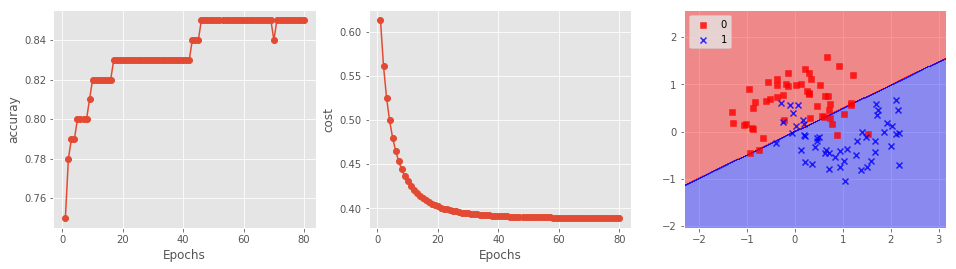

In [441]:
lr=LogisticRegression(eta=0.01,n_iter=80,lambd=1)
lr.fit(x_moon,y_moon)
fig,ax = plt.subplots(1,3, figsize=(16,4))

ax[0].plot(range(1,len(lr.acc_)+1),lr.acc_,marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel("accuray")
ax[1].plot(range(1,len(lr.cost_)+1),lr.cost_,marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel("cost")

plot_decision_regions(x_moon,y_moon,classifier=lr)

ax[2].legend(loc='upper left')

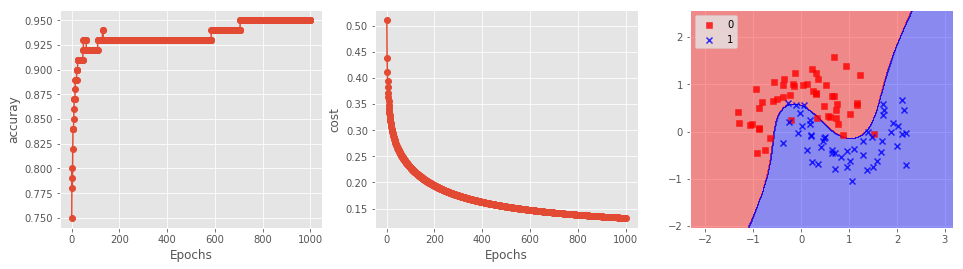

In [442]:
#使用多项式特征
lr_moon=LogisticRegression(eta=0.01,n_iter=1000,lambd=0,degree=3)

lr_moon.fit(x_moon,y_moon)
fig,ax = plt.subplots(1,3, figsize=(16,4))

ax[0].plot(range(1,len(lr_moon.acc_)+1),lr_moon.acc_,marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel("accuray")
ax[1].plot(range(1,len(lr_moon.cost_)+1),lr_moon.cost_,marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel("cost")
plot_decision_regions(x_moon,y_moon,classifier=lr_moon)

ax[2].legend(loc='upper left')


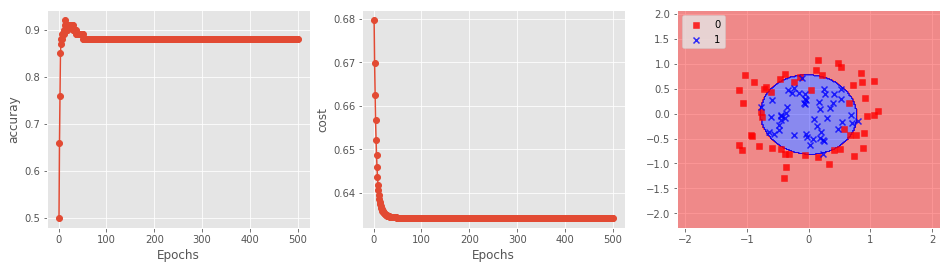

In [450]:
lr_circle=LogisticRegression(eta=0.01,n_iter=500,lambd=10,degree=2)

lr_circle.fit(x_circle,y_circle)
fig,ax = plt.subplots(1,3, figsize=(16,4))

ax[0].plot(range(1,len(lr_circle.acc_)+1),lr_circle.acc_,marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel("accuray")
ax[1].plot(range(1,len(lr_circle.cost_)+1),lr_circle.cost_,marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel("cost")
plot_decision_regions(x_circle,y_circle,classifier=lr_circle)

ax[2].legend(loc='upper left')


***
### 4.神经网络
y=g(w3(w2(w1x+b1)+b2)+b3)

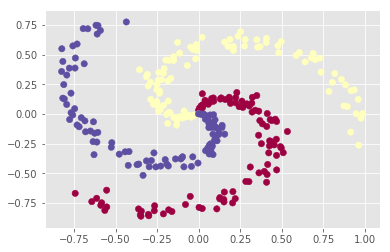

In [10]:
#生成螺旋数据
x_spiral = np.zeros((100*3,2))
y_spiral =  np.zeros(100*3,dtype='uint8')
for j in range(3):
    ix = range(100*j,100*(j+1))
    r = np.linspace(0.0,1,100)
    t = np.linspace(j*4,(j+1)*4,100)+np.random.randn(100)*0.2
    x_spiral[ix] =  np.c_[r*np.sin(t),r*np.cos(t)]
    y_spiral[ix]=j
plt.scatter(x_spiral[:,0],x_spiral[:,1],c=y_spiral,s=40,cmap=plt.cm.Spectral)

In [849]:
class NeuroNetwork(object):
    def __init__(self,h=100,reg=1e3,step_size=1e-0,num_iter=5000):
        self.h = h #隐藏层大小
        self.reg = reg #正则化参数
        self.step_size = step_size #学习速率
        self.num_iter = num_iter #迭代次数
    def fit(self,x,y):
        self.init_parameters(x,y)
        self.cost_ = []
        self.acc_ = []
        for i in range(self.num_iter):
            self.update(x,y)
            self.cost_.append(self.cost(x,y))
            self.acc_.append(self.accuracy(x,y))
        return self
    def init_parameters(self,x,y):
        
        d = x.shape[1]   #特征数  
        h1 = self.h    
        c = len(pd.unique(y)) #输出类别
        
        self.w1 =  0.01 *np.random.randn(d,h)
        self.b1 = np.zeros((1,h))
        self.w2 =  0.01 *np.random.randn(h,c)
        self.b2 = np.zeros((1,c))
        return self
    def forward(self,x,y):
        m = x.shape[0]
        hidden_layer = np.maximum(0,np.dot(x,self.w1)+self.b1) #隐藏层的激活值，使用relu激活函数
        scores = np.dot(hidden_layer,self.w2)+self.b2 #输出层的得分
        exp_scores =np.exp(scores+np.log(10)) #加上np.log(10)增加数值稳定性
        probs =  exp_scores/exp_scores.sum(axis=1,keepdims=True) #计算概率
        return hidden_layer,scores,probs
    def cost(self,x,y):
        _,_,probs = self.forward(x,y)
        

        #计算损失
        m = x.shape[0]
        corect_logprobs = -np.log(probs[range(m),y]) #不能用 ： 代替range(m)
        data_loss = np.sum(corect_logprobs)/m

        reg_loss = 0.5*reg*np.sum(self.w1*self.w1)+0.5*reg*np.sum(self.w2*self.w2)

        return data_loss + reg_loss
        
    def update(self,x,y):
        #前向传播
        hidden_layer,scores,probs = self.forward(x,y)

        #计算梯度
        m = x.shape[0]
        dscores = probs
        dscores[range(m),y] -= 1   # softmax的梯度
        dscores /= m

        dw2 = np.dot(hidden_layer.T,dscores)
        db2 = np.sum(dscores,axis=0,keepdims=True)
        dhidden = np.dot(dscores,self.w2.T)
        dhidden[hidden_layer <= 0] = 0
        dw1 = np.dot(x.T,dhidden)
        db1 = np.sum(dhidden,axis=0,keepdims=True)
        dw2 += reg * self.w2
        dw1 += reg * self.w1

        self.w1 += -step_size * dw1
        self.b1 += -step_size * db1
        self.w2 += -step_size * dw2
        self.b2 += -step_size * db2
        return self
    def predict(self,x):
        hidden_layer = np.maximum(0,np.dot(x,self.w1)+self.b1)
        scores = np.dot(hidden_layer,self.w2)+self.b2
        predicted_class = np.argmax(scores,axis=1)
        return predicted_class
    def accuracy(self,x,y):

        return np.mean(self.predict(x)==y)

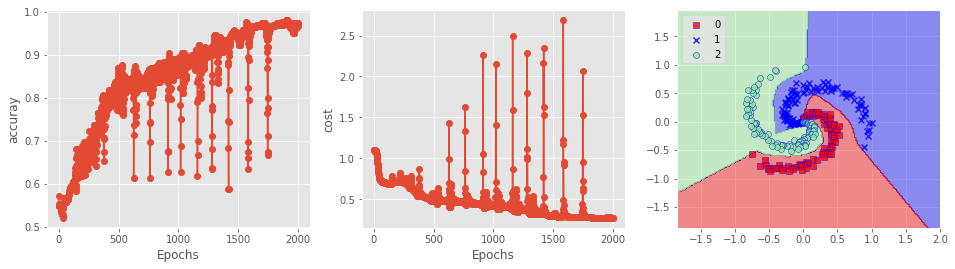

In [847]:
nn_spiral=NeuroNetwork(h=100,reg=1e3,step_size=1e-0,num_iter=2000)
nn_spiral.fit(x_spiral,y_spiral)
fig,ax = plt.subplots(1,3, figsize=(16,4))

ax[0].plot(range(1,len(nn_spiral.acc_)+1),nn_spiral.acc_,marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel("accuray")
ax[1].plot(range(1,len(nn_spiral.cost_)+1),nn_spiral.cost_,marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel("cost")
plot_decision_regions(x_spiral,y_spiral,classifier=nn_spiral)

ax[2].legend(loc='upper left')

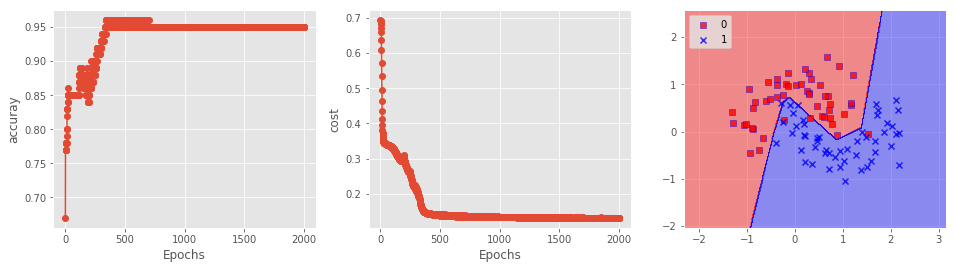

In [842]:
nn_moon=NeuroNetwork(h=100,reg=1e3,step_size=1e-0,num_iter=1000)
nn_moon.fit(x_moon,y_moon)
fig,ax = plt.subplots(1,3, figsize=(16,4))

ax[0].plot(range(1,len(nn_moon.acc_)+1),nn_moon.acc_,marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel("accuray")
ax[1].plot(range(1,len(nn_moon.cost_)+1),nn_moon.cost_,marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel("cost")
plot_decision_regions(x_moon,y_moon,classifier=nn_moon)

ax[2].legend(loc='upper left')

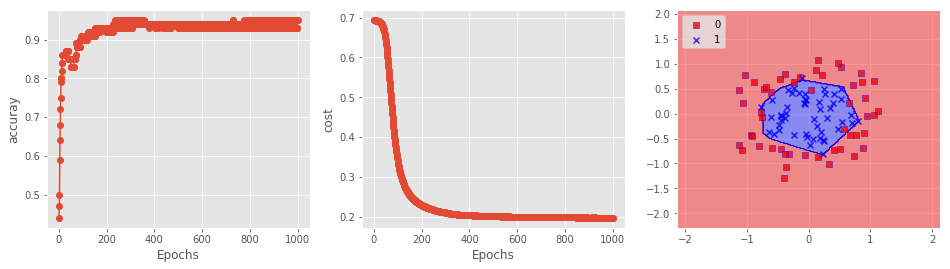

In [851]:
nn_circle=NeuroNetwork(h=100,reg=1e3,step_size=1e-0,num_iter=1000)
nn_circle.fit(x_circle,y_circle)
fig,ax = plt.subplots(1,3, figsize=(16,4))

ax[0].plot(range(1,len(nn_circle.acc_)+1),nn_circle.acc_,marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel("accuray")
ax[1].plot(range(1,len(nn_circle.cost_)+1),nn_circle.cost_,marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel("cost")
plot_decision_regions(x_circle,y_circle,classifier=nn_circle)

ax[2].legend(loc='upper left')

*** 
### 5.卷积神经网络

In [123]:
# Pad
def zeros_padding(x,pad):
    # x: (m,n_h,n_w,n_c)
    
    return np.pad(x,((0,0),(pad,pad),(pad,pad),(0,0)),mode='constant')
def conv_single_step(a_slice_prev, W, b):
    s = a_slice_prev*W

    Z = np.sum(s)
    Z = Z+float(b)
    return Z
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from A_prev's shape (≈1 line)  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape (≈1 line)
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters" (≈2 lines)
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume using the formula given above. Hint: use int() to floor. (≈2 lines)
    n_H = int((n_H_prev+2*pad-f)/stride+1)
    n_W = int((n_W_prev+2*pad-f)/stride+1)
    
    # Initialize the output volume Z with zeros. (≈1 line)
    Z = np.zeros((m,n_H,n_W,n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev,pad)
    
    for i in range(m):                               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]                               # Select ith training example's padded activation
        for h in range(n_H):                           # loop over vertical axis of the output volume
            for w in range(n_W):                       # loop over horizontal axis of the output volume
                for c in range(n_C):                   # loop over channels (= #filters) of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h*stride
                    vert_end = f+h*stride
                    horiz_start = w*stride
                    horiz_end = f+w*stride
                    
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈1 line)
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:,:,:,c], b[:,:,:,c])
                                        
    ### END CODE HERE ###
    
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

***
### 5.SVM 

In [278]:
#支持向量机 ，二次规划求解
#将问题转化的二次规划求解问题
